## Классический PageRank

### Обозначения

Пусть дан граф $G = (V, E)$.

$A_{ij} = I_{i \to j}$ -- матрица связности $G$.

$D = diag(A [1, \ldots, 1]^T)$ - матрица степеней вершин.

$P = A^T D^{-1}$ - матрица марковского процесса блуждания по графу. $P$ - столбцово-стохастическая.

### Обыкновенное блуждание по графу

Пусть $x^0$ - вероятностный вектор распределения по вершинам графа, т.е. $x_i^0 \geq 0$ и $\sum\limits_i x_i^0 = 1$.
Тогда на $k+1$-ом шаге в цепочке блуждания:
$$x^{k+1} = P x^k.$$

### PageRank блуждание

В отличие от обыкновенного, на каждом шаге с некоторой вероятностью $(1 - \alpha)$ мы переносимся в случайную вершину графа. 
Вероятность попасть в вершину при "телепортации" равна $v_i$. 
Таким образом:
$$x^{k+1} = \alpha P x^k + (1 - \alpha) v = \tilde{P} x^k,$$
где $\tilde{P} = \alpha P + (1 - \alpha) v \textbf{1}^T$.

### Стационарное состояние

Вектор $x^*$ называется стационарным, если $x^* = P x^*$.
В случае обыкновенного блуждания он является собственным ветокром матрицы $P$.
В случае PageRank $x^*$ должен удовлетворять уравнению:
$$(I - \alpha P) x = (1 - \alpha) v.$$

## Временное обобщение

Рассмотрим разностную схему с шагом по времени $\Delta t = 1$:
$$x^{k+1} - x^k = \alpha P x^k + (1 - \alpha) v - x^k = (1 - \alpha) v - (I - \alpha P) x^k.$$
Можно рассмотреть соответствующую систему ОДУ:
$$x'(t) = (1 - \alpha) v - (I - \alpha P) x(t)$$
или более общий её вид с ветором телепортации, зависящим от времени:
$$x'(t) = (1 - \alpha) v(t) - (I - \alpha P) x(t).$$

У данной системы есть аналитическое решение:
$$x(t) = \exp(-(I - \alpha P)t)x(0) + (1 - \alpha) \int\limits_0^t \exp(-(I - \alpha P)(t - \tau)) v(\tau) d\tau.$$
Можно решать итерационно, например, явным методом Эйлера:
$$x(t + h) = x(t) + h [(1 - \alpha) v(t) - (I - \alpha P) x(t)]$$
Он устойчив при $h < \dfrac{2}{1 + \alpha}$. 
Соответственно, при $h < 1$ метод устойчив для любого $\alpha \in [0, 1]$.

In [ ]:
!mkdir data

In [1]:
!pip install networkx

Defaulting to user installation because normal site-packages is not writeable


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import imageio
from scipy.integrate import solve_ivp
from scipy.linalg import eig

from sklearn.metrics import pairwise_distances

import networkx as nx

In [3]:
# random graph
N = 5
A = np.zeros(shape=(N, N))
while (A.sum(axis=1) == 0).any():
    A = np.random.randint(0, 2, size=(N, N))
    for i in range(N):
        A[i, i] = 0
        for j in range(i):
            yes = max(A[i, j], A[j, i])
            A[i, j] = A[j, i] = yes
P = A.T @ np.diag(1 / A.sum(axis=1))
assert(np.allclose(P.sum(axis=0), 1.0))

In [4]:
A, P

(array([[0, 1, 1, 1, 0],
        [1, 0, 1, 0, 1],
        [1, 1, 0, 0, 0],
        [1, 0, 0, 0, 1],
        [0, 1, 0, 1, 0]]),
 array([[0.        , 0.33333333, 0.5       , 0.5       , 0.        ],
        [0.33333333, 0.        , 0.5       , 0.        , 0.5       ],
        [0.33333333, 0.33333333, 0.        , 0.        , 0.        ],
        [0.33333333, 0.        , 0.        , 0.        , 0.5       ],
        [0.        , 0.33333333, 0.        , 0.5       , 0.        ]]))

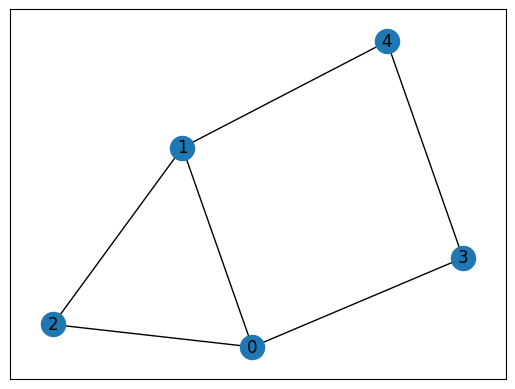

In [5]:
graph = nx.from_numpy_array(A, parallel_edges=True)
nx.draw_networkx(graph)

In [6]:
def Px_matvec(x):
    global P
    return P @ x

def v_static_fn(t):
    global N
    v = np.ones(N) / N
    return v

def v_cyclic_fn(t):
    global N
    v = np.zeros(N)
    v[int(t / 2) % N] = 1
    v = v.reshape(1, N)
    return v

In [7]:
alpha = 0.85
h = 1
t_max = 20
x0 = v_static_fn(0)

In [8]:
def fwd_euler(h, t_max, alpha, x0, Px_fn, v):
    if h > 2 / (1 + alpha):
        print("Too big time step, solution may be ustable")
    N = len(x0) # number of graph vertices
    n_steps = int((t_max / h) + 1)
    X = np.zeros(shape=(N, n_steps + 1))
    X[:, 0] = x0
    for k in range(n_steps):
        t = h * k
        Px = Px_fn(X[:, k])
        X[:, k + 1] = (1 - h) * X[:, k] + h * ((1 - alpha) * v(t) + alpha * Px)
    return X

In [9]:
Xeul_stat = fwd_euler(h, t_max, alpha, x0, Px_matvec, v_static_fn)
Xeul_cycl = fwd_euler(h, t_max, alpha, x0, Px_matvec, v_cyclic_fn)

In [10]:
colors = ['black', 'red', 'green', 'yellow', 'blue']

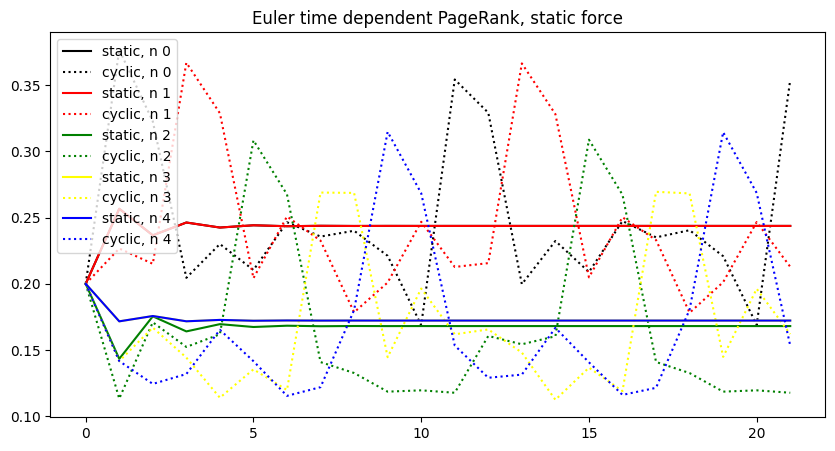

In [11]:
tm = np.arange(Xeul_stat.shape[1])
plt.figure(figsize=(10, 5))
for i in range(N):
    plt.plot(tm, Xeul_stat[i, :], linestyle='solid', color=colors[i], label=f'static, n {i}')
    plt.plot(tm, Xeul_cycl[i, :], linestyle='dotted', color=colors[i], label=f'cyclic, n {i}')
plt.title("Euler time dependent PageRank, static force")
plt.legend()
plt.show()

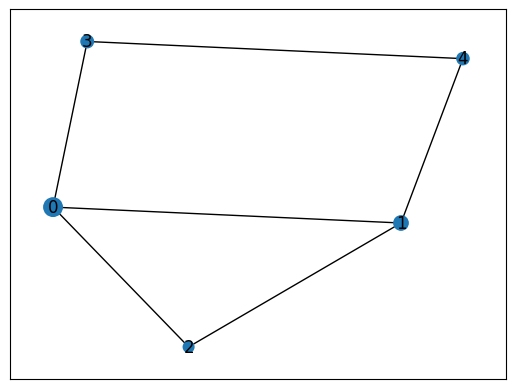

In [12]:
nx.draw_networkx(graph, node_size=500*Xeul_cycl[:, -1])

In [13]:
def save_graph_gif(G, probs, string=''):
    
    t_max = probs.shape[1]
    layout = nx.circular_layout(G)
    
    for i in range(t_max):
        f = plt.figure()
        nx.draw_networkx(graph, pos=layout, ax=f.add_subplot(111), node_size=10000*probs[:, i])
        plt.title(f'time={i}')
        plt.savefig(f'data/fig_{string}_{i}')
        plt.close(f)
        
    frames = []
    for t in range(t_max):
        image = imageio.v2.imread(f'./data/fig_{string}_{t}.png')
        frames.append(image)

    imageio.mimsave(f'./graph_{string}.gif', # output gif
                    frames,          # array of input frames
                    fps = 4)

In [14]:
save_graph_gif(graph, Xeul_cycl, 'eul_graph')

## Двумерный пример 

In [15]:
n_clusters = 4
n_cluster_pts = 100
n_pts = n_cluster_pts * n_clusters
n_neighbors = 10#n_cluster_pts
var = 0.9
colors = ['black', 'red', 'green', 'yellow', 'blue']
markers = ['.', '+', 'x', 'd', 's']
p_random_connection = 2 / n_pts

In [16]:
points = np.zeros(shape=(2, n_pts))
for c in range(n_clusters):
    angle = 2 * np.pi * c / n_clusters
    center = np.array([np.cos(angle), np.sin(angle)])
    for j in range(n_cluster_pts):
        points[:, c * n_cluster_pts + j] = center + var * np.random.randn(1, 2)

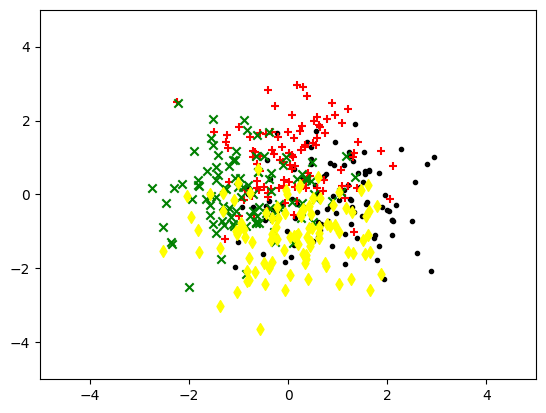

In [17]:
plt.xlim([-5, 5])
plt.ylim([-5, 5])
for c in range(n_clusters):
    class_pts = points[:, c * n_cluster_pts : (c + 1) * n_cluster_pts]
    plt.scatter(class_pts[0], class_pts[1], color=colors[c], marker=markers[c])

In [18]:
distances = pairwise_distances(points.T)
A_graph = np.zeros((n_pts, n_pts))
for i in range(n_pts):
    closest_idx = np.argpartition(distances[i], n_neighbors)[:n_neighbors]
    for j in closest_idx:
        A_graph[i, j] = A_graph[j, i] = 1
    for j in range(n_pts):
        if np.random.uniform(0, 1) < p_random_connection:
            A_graph[i, j] = A_graph[j, i] = 1

In [19]:
P = A_graph.T @ np.diag(1 / A_graph.sum(axis=1))
assert(np.allclose(P.sum(axis=0), 1.0))

Пусть каждые 10 единиц вермени "интерес" смещается в следующий кластер.

In [20]:
def Px_matvec(x):
    global P
    return P @ x.flatten()

def v_cyclic_fn(t):
    global n_clusters
    global n_cluster_pts
    cls = int(t / 10) % n_clusters
    v = np.zeros(n_pts)
    v[cls * n_cluster_pts : (cls + 1) * n_cluster_pts] = 1 / n_cluster_pts
    v = v.reshape(1, n_pts)
    return v

In [21]:
alpha = 0.85
h = 1
t_max = 100

x0 = np.ones(shape=(n_pts)) / n_pts

In [22]:
Xeul = fwd_euler(h, t_max, alpha, x0, Px_matvec, v_cyclic_fn)

In [23]:
def save_pics_gif(probs, string=''):
    global points
    global n_clusters
    global n_cluster_pts
    global markers
    
    t_max = probs.shape[1]
    
    for i in range(t_max):
        plt.xlim([-5, 5])
        plt.ylim([-5, 5])
        for c in range(n_clusters):
            class_pts = points[:, c * n_cluster_pts : (c + 1) * n_cluster_pts]
            class_prob = probs[c * n_cluster_pts : (c + 1) * n_cluster_pts, i]
            plt.scatter(class_pts[0], class_pts[1], c=class_prob, marker=markers[c])
        plt.title(f'time = {i:3}')
        
        if i == 0:
            plt.colorbar()
        plt.savefig(f'data/fig_{string}_{i}')
    
    frames = []
    for t in range(t_max):
        image = imageio.v2.imread(f'./data/fig_{string}_{t}.png')
        frames.append(image)

    imageio.mimsave(f'./graph_{string}.gif', # output gif
                    frames,          # array of input frames
                    fps = 4)

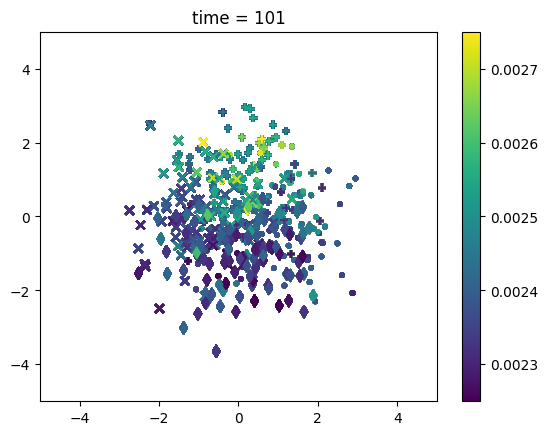

In [24]:
save_pics_gif(Xeul, 'eul')

### Сравнение с PageRank

In [25]:
def ode_rhs(t, x):
    global alpha
    global v
    global Px_matvec
    return (1 - alpha) * v(t) - x + alpha * Px_matvec(x)

In [26]:
alpha = 0.85
h = 1
t_max = 100

time_points = np.arange(0, t_max, 1)

Xtd = np.zeros(shape=(n_pts, len(time_points)))

x0 = np.ones(shape=(n_pts)) / n_pts
v = v_cyclic_fn
Xtd[:, 0] = x0

for k, tp in enumerate(time_points[:-1]):
    solution = solve_ivp(ode_rhs, (tp, time_points[k + 1]), Xtd[:, k])
    Xtd[:, k + 1] = solution.y[:, -1]    

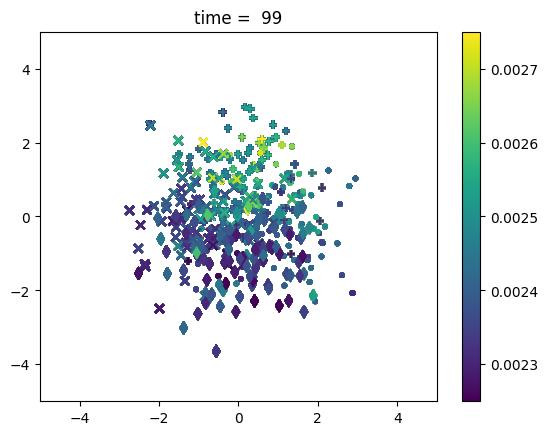

In [27]:
save_pics_gif(Xtd, 'ode')

In [28]:
# classic PageRank

Xpr = np.zeros(shape=(n_pts, len(time_points)))

for k, tp in enumerate(time_points[:-1]):
    v_cur = v(tp)
    x_prev = np.ones(n_pts) / n_pts
    x_next = np.zeros(n_pts)
    while np.linalg.norm(x_prev - x_next) > 1e-4:
        x_prev = x_next
        x_next = alpha * Px_matvec(x_prev) + (1 - alpha) * v_cur
        x_next /= x_next.sum()
    Xpr[:, k] = x_next

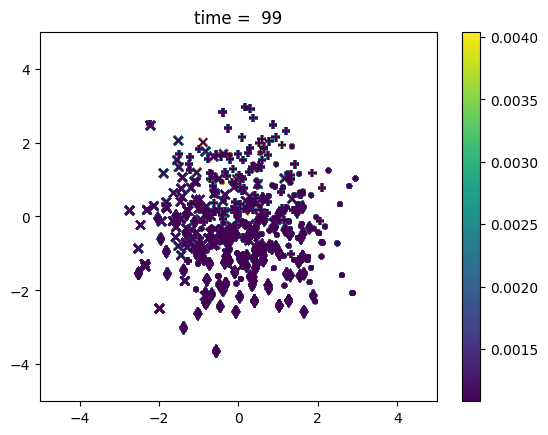

In [29]:
save_pics_gif(Xpr, 'pr')

In [30]:
np.linalg.norm(Xpr - Xtd)

0.16383723585126492

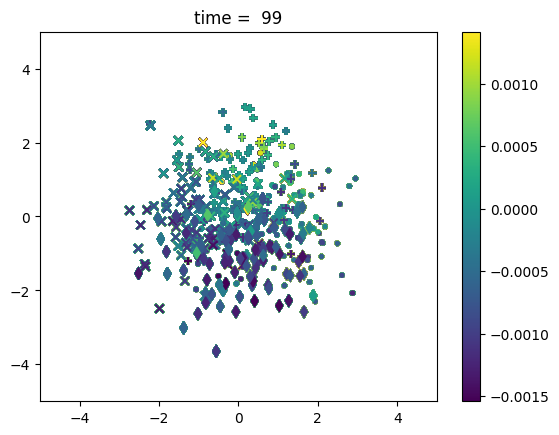

In [31]:
save_pics_gif(Xtd - Xpr, 'diff')

In [32]:
smp_idx = [10, 110, 210, 310]
smpX = Xtd[smp_idx, :99]
smpXpr = Xpr[smp_idx, :99]
time = time_points[:99]

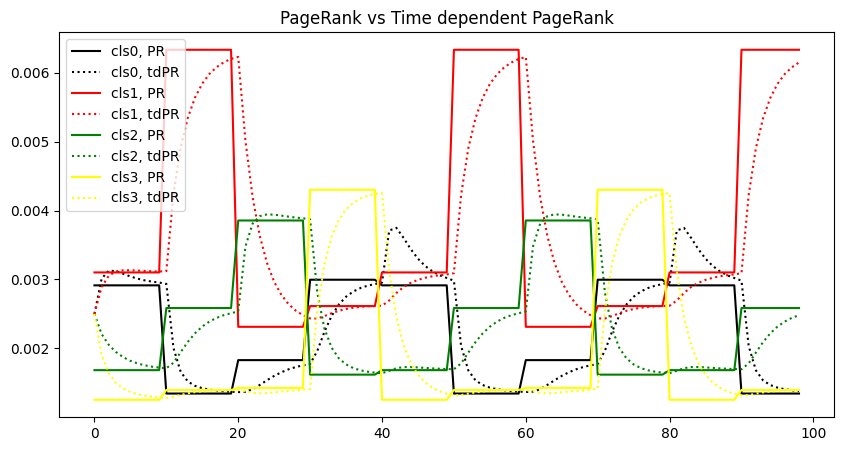

In [33]:
plt.figure(figsize=(10, 5))
for i in range(4):
    plt.plot(time, smpXpr[i, :], linestyle='solid', color=colors[i], label=f'cls{i}, PR')
    plt.plot(time, smpX[i, :], linestyle='dotted', color=colors[i], label=f'cls{i}, tdPR')
plt.title("PageRank vs Time dependent PageRank")
plt.legend()
plt.show()